In [97]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import pandas as pd
import xml.etree.ElementTree as ET

from collections import Counter
from glob import glob
from os import path as pathlib

%matplotlib inline

In [112]:

class JSON(object):
    """
    Helper Class For Mapping JSON vars to Objects
    """
    def __init__(self,data=dict(),inner=False):
        for key in data:
            if type(data[key]) == dict:
                self.__dict__[key] = JSON(data[key],inner=True)
            else:
                self.__dict__[key] = data[key]

    def __repr__(self):
        return self.__dict__.__str__()
    
    def __str__(self):
        return self.__dict__.__str__()
    
    def __getitem__(self,key):
        return self.__dict__[key]
    
    def __setitem__(self,key,value):
        self.__dict__[key] = value
    
    def __iter__(self):
        for key in self.__dict__:
            if type(self.__dict__[key]) == JSON:
                yield key, self.__dict__[key]()
            else:
                yield key, self.__dict__[key]
        
    def __call__(self,):
        return {i:j for i,j in  self.__iter__()}

class XMLParser(object):
    """
    XML parser/helper 
    """
    def __init__(
            self,
            path:str,
        ):
        self.path = pathlib.abspath(path)
        self.data = []

    def __getitem__(self,key):
        return self.data[key]
    
    def __len__(self,):
        return len(self.data)

    def __repr__(self):
        return f"XMLParser @ {self.path}"

    def parse(self,):
        data = []
        for p in glob(pathlib.abspath(f"{self.path}/annotations/*.xml")):
            try:
                tree = ET.parse(p)
            except:
                continue
            row = JSON()
            row.filename = tree.find("filename").text
            row.path = pathlib.abspath(f"{self.path}/images/{row.filename}")
            row.height = int(tree.find("size").find("height").text)
            row.width = int(tree.find("size").find("width").text)
            boxes = []
            for o in tree.findall("object"):
                box = JSON()
                box.category = o.find("name").text
                for c in ['xmin','ymin','xmax','ymax']:
                    box[c] = int(o.find("bndbox").find(c).text)
                
                box.h = (box.ymax - box.ymin) / row.height
                box.w = (box.xmax - box.xmin) / row.width

                box.y = (box.ymin / row.height ) + (box.h / 2 ) 
                box.x = (box.xmin / row.width ) + (box.w / 2 ) 

                boxes.append(box)
            row['boxes'] = boxes
            data.append(row)
        self.data = data

    def as_dataframe(self,):
        rows = []
        for row in self.data.copy():
            for box in row.boxes:
                box.path = row.path
                box.filename = row.filename
                box.width = row.width
                box.height = row.height
                rows.append(box)
        
        return pd.DataFrame([r() for r in rows])

In [113]:
data = XMLParser("./datasets/PotHoles/")

In [114]:
data.parse()

In [115]:
data

XMLParser @ C:\workspace\detect\datasets\PotHoles

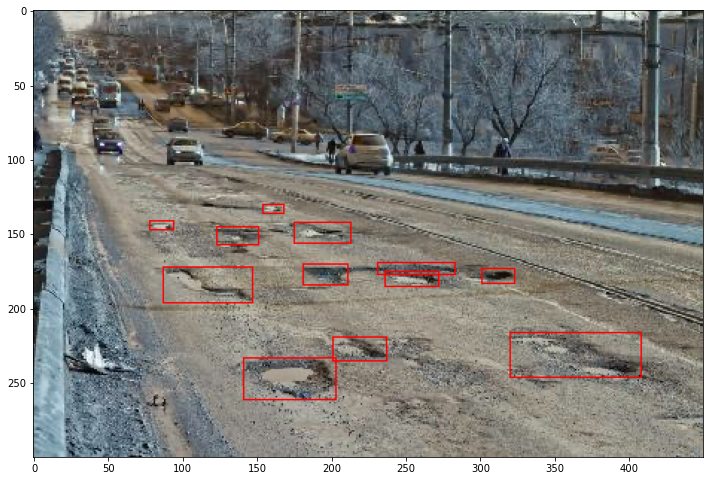

In [118]:
d = data[0]

img = cv2.imread(d.path)


for b in d.boxes:
    xmin = int(b.x*d.width) - int(b.w*d.width)//2
    ymin = int(b.y*d.height) - int(b.h*d.height)//2
    
    xmax = int(b.x*d.width) + int(b.w*d.width)//2
    ymax = int(b.y*d.height) + int(b.h*d.height)//2
    
    img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)

    
plt.figure(figsize=(12,12))
plt.imshow(img)

In [119]:
IMG_SIZE = 384

In [121]:
def read_images(data,img_size):
    pass

In [122]:
class BoxGrid(object):
    """
    Encodes Box
    """
    def __init__(self,low,high):
        self.low = low
        self.high = high
        self.repr = f"""
BoxGrid(
    low={self.low},
    high={self.high}
)
        """
    
    def __repr__(self):
        return self.repr
    
    def encode(self,h,w):
        return h/self.high,w/self.high
    
    def get_pair(self,y,x,h,w):
        h = int(h*self.high)
        w = int(w*self.high)
        return (x - (h//2),y - (h//2)),(x + (h//2),y + (h//2))
    
    def decode(self,):
        pass
    
    def encodeBatch(self,):
        pass
    
    def decodeBatch(self,):
        pass

In [154]:
class AnchorGrid(object):
    
    def __init__(self,resize_factor,k,image_size,box_gen):
        
        self.k = k
        self.resize_factor = resize_factor
        self.image_size = image_size
        self.grid_size = image_size // resize_factor
        self.box_gen = BoxGrid(**box_gen)
        self.length = self.grid_size*self.grid_size*self.k
        
        
        self.repr = f"""
AnchorGrid (
    resize_factor={self.resize_factor},
    k={self.k},
    image_size={self.image_size},
    grid_size={self.grid_size}
)"""
        
    def __repr__(self,):
        return self.repr
                
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        box = np.zeros((self.grid_size,self.grid_size,self.k,4))
        prob_0 = np.zeros((self.grid_size,self.grid_size,self.k,1))
        prob_1 = np.ones((self.grid_size,self.grid_size,self.k,1))
        prob = np.concatenate((prob_1,prob_0),axis=3)        
        
        data = data[np.logical_and(np.all(data[:,2:] <= self.box_gen.high,axis=1), np.any(data[:,2:] > self.box_gen.low,axis=1))]
        _counter = Counter()

        for y,x,h,w in data:
            Ox = int(x // self.resize_factor) 
            Oy = int(y // self.resize_factor) 
            if Ox == self.grid_size or Oy == self.grid_size:
                continue

            x = (x - (Ox*self.resize_factor)) / self.resize_factor
            y = (y - (Oy*self.resize_factor)) / self.resize_factor
            h,w = self.box_gen.encode(h,w)
                        
            Oi = _counter[f"{Oy}x{Ox}"]
            
            assert Oi < self.k,f"More Boxes Then Assigned K, {self.repr}"
            
            box[Oy,Ox,Oi,:] = [y,x,h,w]
            prob[Oy,Ox,Oi,:] = [0,1]
            
            _counter[f"{Oy}x{Ox}"] += 1

        prob,box =  prob.reshape(-1,self.k,2),box.reshape(-1,self.k,4)
        return prob.reshape(-1,2),box.reshape(-1,4)
    
    def encode(self,data):
        return self.__call__(data)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,self.k,1).reshape(self.grid_size,self.grid_size,self.k).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy()
        mask = prob > thresh
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        boxes = boxes[mask]
        boxes[:,2:] = boxes[:,2:] * self.box_gen.high
        return boxes.astype(int)
        
    def generate(self,ret=False):
        xx,yy = np.meshgrid(np.arange(self.grid_size),np.arange(self.grid_size))
        xx,yy = np.reshape(xx,(self.grid_size,self.grid_size,1)),np.reshape(yy,(self.grid_size,self.grid_size,1))
        self.reference = np.concatenate((yy,xx),axis=-1)
        self.grid = self.reference.copy() * self.resize_factor
        self.grid += self.resize_factor // 2
        self.grid_decode = self.grid.copy().reshape(self.grid_size,self.grid_size,1,2).repeat(self.k,axis=2)
        if ret:
            return self.grid.copy(),self.reference.copy()

    def plot_grid(self,img,axes,prob,boxes):
        prob = prob.reshape(-1,self.k,1).reshape(self.grid_size,self.grid_size,self.k).copy()
        boxes = boxes.reshape(-1,self.k,4).reshape(self.grid_size,self.grid_size,self.k,4).copy()
        boxes[:,:,:,:2] = ((boxes[:,:,:,:2] * self.resize_factor) + self.grid_decode).astype(int) - (self.resize_factor // 2)
        
        for ba,pa,(y,x) in zip(boxes.reshape(-1,self.k,4),prob.reshape(-1,self.k,1),self.grid.reshape(-1,2)):
            img = cv2.circle(img,(x,y),2,(255,255,0),-1)
            img = cv2.rectangle(
                        img,
                        (x-(self.resize_factor//2),y-(self.resize_factor//2)),
                        (x+(self.resize_factor//2),y+(self.resize_factor//2)),
                        (255,255,0),
                        1
                    )
            for (y,x,h,w),p in zip(ba,pa):
                xmin = int(x - (w*self.box_gen.high//2))
                ymin = int(y - (h*self.box_gen.high//2))
                xmax = int(x + (w*self.box_gen.high//2))
                ymax = int(y + (h*self.box_gen.high//2))
                
                img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),1)
            
        axes.imshow(img)

In [155]:
class Anchors(object):
    """
    Encode Various Sizes Of FPNS
    """
    
    def __init__(self,img_size,config,):
        self.img_size = img_size
        self.config = config
        
        for cfg in config:
            self.__dict__[f"ANCHOR_{cfg['name']}"] = AnchorGrid(**cfg['anchor_grid'])
            self.__dict__[f"ANCHOR_{cfg['name']}"].generate()
        
        self.ANCHORS = [i for (i,j) in self.__dict__.items() if "ANCHOR_" in i]
        
    def __repr__(self,):
        return self.config.__repr__()
    
    def __call__(self,data):
        """
        Returns : encoded_prob,encoded_box
        """
        boxt = np.round(np.array([[b.y,b.x,b.h,b.w] for b in data.boxes])*self.img_size).astype(np.float32)
        boxt = pd.DataFrame(boxt,columns=['y','x','h','w']).sort_values(by=['y','x','h','w']).values

        prob,box = [],[]
        
        for anchor in self.ANCHORS:
            p,b = self.__dict__[anchor](boxt)
            prob.append(p)
            box.append(b)
            
        prob = np.concatenate(prob,axis=0)
        box = np.concatenate(box,axis=0)
            
        return prob,box
    
    def encode(self,data):
        return self.__call__(data)
    
    def encode_batch(self,data):
        prob,boxes = [],[]
        for d in data:
            p,b = self.__call__(d)
            prob.append(p)
            boxes.append(b)
        return np.array(prob),np.array(boxes)
    
    def decode(self,prob,boxes,thresh=0.9):
        prob = prob.reshape(-1,2).argmax(axis=1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        ret_boxes = []
        for anchor in self.ANCHORS:
            index = self.__dict__[anchor].length
            batch_ = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            batch = self.__dict__[anchor].decode(*batch_,thresh=thresh)
            last = last+index
            ret_boxes.append(batch)
                       
        return np.concatenate(ret_boxes,axis=0).astype(np.uint32)
    
    def decode_batch(self,prob,boxes):
        pass
    
    def plot_grid(self,img,prob,boxes):
        img = cv2.resize(img.copy(),(self.img_size,self.img_size))
        fig,axes = plt.subplots(len(self.ANCHORS),1,figsize=(14,14*len(self.ANCHORS)))
                
        prob = prob.reshape(-1,2).argmax(axis=1)
        boxes = boxes.reshape(-1,4)
        
        last = 0
        for anchor,ax in zip(self.ANCHORS,axes):
            index = self.__dict__[anchor].length
            batch = (prob[last:last+index].copy(),boxes[last:last+index].copy())
            self.__dict__[anchor].plot_grid(img.copy(),ax,*batch)
            last = last+index

In [161]:
anchor_config = {
    "img_size":IMG_SIZE,
    "config":[
        {
            
            "anchor_grid":{
                "resize_factor":32,
                "k":5,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":8,
                    "high":48
                }
            },
            "name":"FPN0"
        },
        {
            "anchor_grid":{
                "resize_factor":64,
                "k":4,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":48,
                    "high":96
                }
            },
            "name":"FPN1"
        },
        {
            "anchor_grid":{
                "resize_factor":128,
                "k":3,
                "image_size":IMG_SIZE,
                "box_gen":{
                    "low":96,
                    "high":192
                }
            },
            "name":"FPN2"
        }
    ]
}

In [162]:
anchors = AnchorGen(**anchor_config)

In [163]:
y_prob,y_boxes = anchors.encode_batch(data)

In [165]:
y_prob.shape

(665, 891, 2)

(665, 891, 4)